In [1]:
import os
from os.path import isdir, exists, join
import nibabel as nib
from matplotlib import pyplot as plt
import torchio as tio
from multiprocessing import Pool


/labs/gevaertlab/users/thomas/miniconda/envs/multimodal/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create Brain masks

In [ ]:
DATA_DIR = "../data/MR/REMBRANDT"
cases = [f for f in os.listdir(DATA_DIR) if isdir(join(DATA_DIR, f))]

def create_mask(case):
    if not exists(join(DATA_DIR, case, "brain_mask.nii.gz")):
        print(f"\nProcessing {case}")
        t1_path = [join(DATA_DIR, case,f) for f in os.listdir(join(DATA_DIR, case)) if "t1" in f.lower()][0]
        img = nib.load(t1_path)
        brain_mask = (img.get_fdata() > 1)
        brain_mask = brain_mask.astype(float)
        final_brain_mask = nib.Nifti1Image(brain_mask, img.affine)  
        nib.save(final_brain_mask, join(DATA_DIR, case, "brain_mask.nii.gz"))
    else:
        print(f"\n{case} Already masked.")


pool = Pool(20)
pool.map(create_mask,cases)

# Viewer

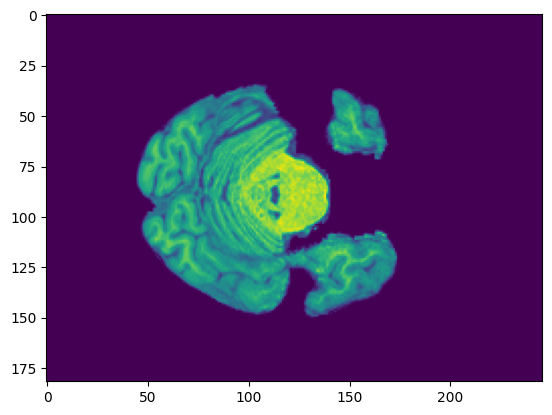

In [30]:
img = nib.load("../data/MR/UKBIOBANK/1799943/1799943_T1.nii.gz").get_fdata()
plt.imshow(img[:,:,60])

# Create binned survival TCGA

In [8]:
import pandas as pd
n=6
df = pd.read_csv("data/survival/survival_data.csv")
df['survival_bin'] = pd.qcut(df['survival_months'], n, labels = [x for x in range(n)])
df['survival_bin'].value_counts()

df.to_csv("data/survival/TCGA_survival_bins.csv")

# Model comparisons

In [49]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ROOT = "/home/tbarba/projects/MultiModalBrainSurvival/"
os.chdir(ROOT)

def ls_dironly(path):
    dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    return dirs


def summarize_models(list_of_models):

    MODELS_DIR = "/home/tbarba/projects/MultiModalBrainSurvival/data/MR/outputs/UNet"

    summary = {}

    for model in list_of_models:
        model_dir = os.path.join(MODELS_DIR, model, "predictions")

        variables_results = dict.fromkeys(ls_dironly(model_dir))

        for var in variables_results.keys():

            try:
                report = pd.read_csv(os.path.join(model_dir, var, "report.csv"))
                if "val_r2_score" in report.columns:
                    variables_results[var] = report['val_r2_score'].iloc[-1]
                else:
                    variables_results[var] = report['val_accuracy'].iloc[-1]
            except:
                variables_results[var] = np.nan
                pass       

        mean_performance = np.array(
            [v for v in variables_results.values()]).mean()
        variables_results["mean_performance"] = mean_performance
        model_sum = pd.DataFrame.from_dict(
            variables_results, orient="index").reset_index()
        model_sum = model_sum.rename(
            columns={"index": "parameter", 0: "performance"})
        model_sum.to_csv(f"{model_dir}/summary.csv", index=False)

        summary[model] = mean_performance

    return summary

list_of_models = [
        "UNet_5b_4f_UKfull",
        "UNet_5b_8f_UKfull",
        "UNet_6b_4f_UKfull",
        "UNet_6b_8f_UKfull"
        ]

summary = summarize_models(list_of_models)
summary = pd.DataFrame.from_dict(summary, orient="index").reset_index()
summary = summary.rename(columns={"index": "model", 0: "mean performance"})
summary.to_csv(
        f"{ROOT}/data/MR/outputs/UNet/overall_summary.csv", index=False)


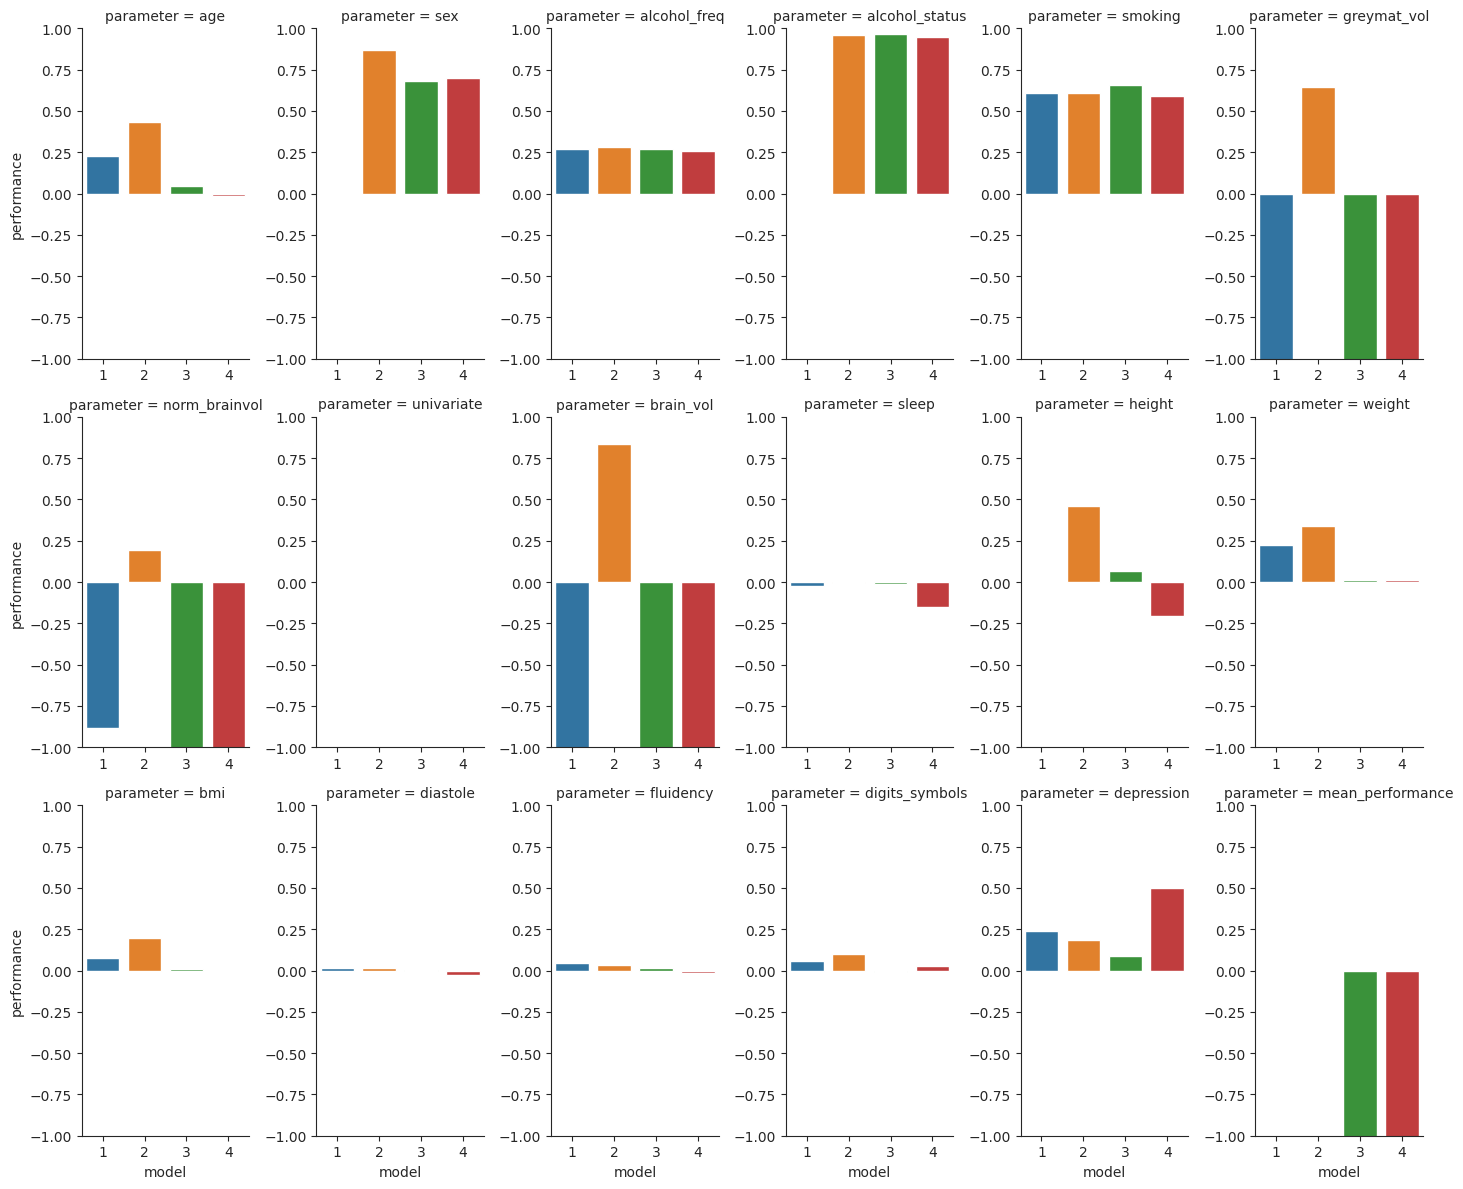

In [50]:
MODELS_DIR = os.path.join(ROOT, "data/MR/outputs/UNet")

def ls_dir(path):
    dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    return dirs

def get_model_summary(model_path):
    summary = None
    try:
        summary = pd.read_csv(model_path + "/predictions/summary.csv")
        summary["model"] = os.path.basename(model_path)
    except FileNotFoundError:
        pass

    return summary


overall = pd.DataFrame()
for model in list_of_models:
    if model.startswith("UNet"):
        model_path = os.path.join(MODELS_DIR, model)

        summary = get_model_summary(model_path)
        overall = pd.concat([overall, summary], axis=0)


# exporting results
overall = pd.DataFrame(overall, columns = ["model","parameter","performance"])
overall.to_csv("results.csv", index=False)

# plotting
overall['model']  = overall['model'].str.replace("UNet_5b_8f_UKfull", "1").str.replace("UNet_5b_4f_UKfull", "2").str.replace("UNet_6b_4f_UKfull", "4").str.replace("UNet_6b_8f_UKfull", "3").astype(int)

g = sns.FacetGrid(overall, col = "parameter", hue="model", col_wrap=6, sharey=False, sharex=False, height=4, aspect=.6)
g.map(sns.barplot,  "model", "performance", order= overall.model.sort_values().unique())
g.set(ylim=(-1, 1))

# plt.figure(figsize=(25,10))
# sns.set_style("ticks")
# bp = sns.barplot(overall, x="parameter",y="performance",hue="model")
# bp.set_ylim((-1,1))


# Update UKB database

In [ ]:
from os.path import join
import shutil

actual = set(ls_dir("/home/tbarba/projects/MultiModalBrainSurvival/data/MR/UKBIOBANK"))
complete = set(pd.read_csv("/home/tbarba/projects/MultiModalBrainSurvival/complete.csv")["eid"].astype(str))

ROOT = "/home/tbarba/projects/MultiModalBrainSurvival/data/MR"

for f in ls_dir(ROOT + "/UKBIOBANK"):
    if f not in complete:
        # shutil.move(join(ROOT, "UKBIOBANK", f), join(ROOT, "UKB_incomplete", f))


# Move from temp location

In [59]:
FROM = "/home/tbarba/storage/uk_biobank_2020/update/data/run41271/downloaded"

for case in ls_dir(FROM):
    shutil.move(FROM+"/"+case, ROOT+"/UKBIOBANK/"+case)

len(ls_dir(ROOT + "/UKBIOBANK"))


5924